# Merge country emissions tables to create "country emissions dataset"

Selected tables come from "03_identify_tables_type.ipynb":

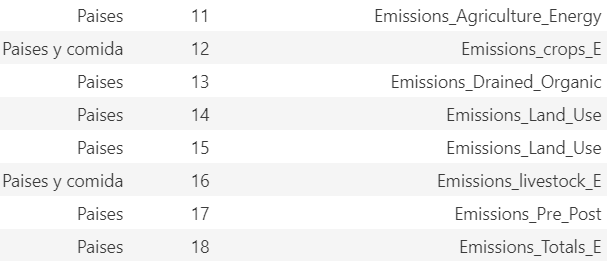

In the end I only used data from table 18: "Emissions Totals"

In [1]:
import pandas as pd
import numpy as np
import zipfile
import io
import os

#supress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
def load_fao_table(table_number, path):
    # Loop through all files in the directory
    for filename in os.listdir(path):
        # Extract the number from the start of the filename
        file_number_str = filename.split('-')[0]
        try:
            file_number = int(file_number_str)
            # Check if the number matches the table number
            if file_number == table_number:
                full_path = os.path.join(path, filename)

                if filename.endswith(".zip"):
                    # Open the zip file
                    with zipfile.ZipFile(full_path, 'r') as zip_ref:
                        # Iterate through the file names in the zip archive
                        for file_name in zip_ref.namelist():
                            # Check if the file name contains the pattern "All_Data_" and ends with .csv
                            if "All_Data" in file_name and file_name.endswith(".csv"):
                                # Read the CSV file into a DataFrame
                                with zip_ref.open(file_name) as file:
                                    return pd.read_csv(file, encoding="ISO-8859-1")

                elif filename.endswith(".csv"):
                    # Read the CSV file into a DataFrame
                    return pd.read_csv(full_path, encoding="ISO-8859-1")

        except ValueError:
            # Handle the case where the filename doesn't start with a valid number
            continue
    
    # Return None if no matching file is found
    return None

## Load country tables and extract features

Iterate through selected country emissions tables and extract features to create "country emissions dataset"

In [3]:
directory = r'../data/FAOSTAT/all_raw'
selected_tables = [18]

In [6]:
selected_items = [
    # 'Total Energy',
    # 'Grassland organic soils',
    # 'Cropland organic soils',
    # 'Drained organic soils',
    # 'Forestland',
    # 'Net Forest conversion',
    # 'Agrifood Systems Waste Disposal',
    # 'Energy Use (Pre- and Post-Production)',
    # 'Fertilizers Manufacturing',
    # 'Food Household Consumption',
    # 'Food Packaging',
    # 'Food Processing',
    # 'Food Retail',
    # 'Food Transport',
    # 'Pre- and Post- Production',
    # 'Solid Food Waste',
    'Crop Residues',                       # table 18
    'Rice Cultivation',                    # table 18
    'Burning - Crop residues',             # table 18
    'Enteric Fermentation',                # table 18
    'Manure Management',                   # table 18
    'Manure left on Pasture',              # table 18
    'Manure applied to Soils',             # table 18
    'Synthetic Fertilizers',               # table 18
    'Forestland',                          # table 18
    'Net Forest conversion',               # table 18
    'Savanna fires',                       # table 18
    'Fires in organic soils',              # table 18
    'Forest fires',                        # table 18
    'Fires in humid tropical forests',     # table 18
    'Agrifood Systems Waste Disposal',     # table 18
    'Fertilizers Manufacturing',           # table 18
    'Food Retail',                         # table 18
    'Food Household Consumption',          # table 18
    'Food Transport',                      # table 18
    'Waste',                               # table 18
    'Agrifood systems',                    # table 18
    'Farm gate',                           # table 18
    'Land Use change',                     # table 18
    'Pre- and Post- Production',           # table 18
    'Emissions on agricultural land',      # table 18
    'Emissions from crops',                # table 18
    'Emissions from livestock',            # table 18
    'Agricultural Soils',                  # table 18
    'Pesticides Manufacturing',            # table 18
    'Food Processing',                     # table 18
    'Food Packaging'                       # table 18
]

selected_elements = [
    'Energy use in agriculture',
    'Area',
    'Net stock change (C)',
    'Net emissions/removals (CO2) (Forest land)',
    'Energy Use (Total)',
    'Emissions (CO2eq) (AR5)'
]

In [7]:
merged_df = pd.DataFrame()

for table in selected_tables:
    # Load the data
    df = load_fao_table(table, directory)

    # Select items defined in the beginning
    df = df[df['Item'].isin(selected_items)]

    # Select elements defined in the beginning
    df = df[df['Element'].isin(selected_elements)]
    
    # Replace spaces and commas in column names
    cols_with_spaces = ['Item', 'Element', 'Unit']
    for col in cols_with_spaces:
        df[col] = df[col].str.replace(' ', '_').str.replace(',', '_')

    # Combine 'Element' and 'Unit' columns
    df['Element'] = df['Item'] + "_" + df['Element'] + "_" + df['Unit']

    # Group by Area, Year, Item, and Element, then sum the values
    grouped = df.groupby(['Area Code', 'Area', 'Year', 'Item', 'Element'])['Value'].sum().reset_index()

    # Pivot the table to have combinations of Items and Elements as columns
    pivot_df = grouped.pivot_table(index=['Area Code', 'Area', 'Year'], 
                                    columns=['Element'], 
                                    values='Value', 
                                    aggfunc='sum').reset_index()

    if merged_df.empty:
        merged_df = pivot_df
    else:
        merged_df = pd.merge(merged_df, pivot_df, on=['Area Code', 'Area', 'Year'], how='outer')

Check for duplicated countries or area codes

In [10]:
# Group by 'Area' and 'Area Code', then count the number of unique Area Codes for each Area
area_code_counts = merged_df.groupby('Area')['Area Code'].nunique()

# Filter areas with more than one unique area code
areas_with_multiple_codes = area_code_counts[area_code_counts > 1]

# Display results
print(areas_with_multiple_codes)

Series([], Name: Area Code, dtype: int64)


## Final merge (emissions)

In [11]:
# country_emissions_df = pd.merge(merged_11_13_df, merged_15_17_18_df, on=['Area Code', 'Area', 'Year'], how='outer')
country_emissions_df = merged_df.copy()

In [12]:
country_emissions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15482 entries, 0 to 15481
Data columns (total 34 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   Area Code                                                   15482 non-null  int64  
 1   Area                                                        15482 non-null  object 
 2   Year                                                        15482 non-null  int64  
 3   Agricultural_Soils_Emissions_(CO2eq)_(AR5)_kt               14806 non-null  float64
 4   Agrifood_Systems_Waste_Disposal_Emissions_(CO2eq)_(AR5)_kt  8406 non-null   float64
 5   Agrifood_systems_Emissions_(CO2eq)_(AR5)_kt                 14994 non-null  float64
 6   Burning_-_Crop_residues_Emissions_(CO2eq)_(AR5)_kt          13355 non-null  float64
 7   Crop_Residues_Emissions_(CO2eq)_(AR5)_kt                    13560 non-null  float64
 

## Adding other country relevant data

I will add from other FAO tables:
- Population
- GDP
- GDP per capita
- Country area

In [13]:
additional_tables = [46, 58, 56]

In [14]:
additional_items = [
    'Country area',
    'Population - Est. & Proj.',
    'Gross Domestic Product'
]

additional_elements = [
    'Area',
    'Total Population - Both sexes',
    'Value US$',
    'Annual growth US$ per capita',
    'Value US$ per capita'
]

In [15]:
merged_df = pd.DataFrame()

for table in additional_tables:
    # Load the data
    df = load_fao_table(table, directory)

    # Select items defined in the beginning
    df = df[df['Item'].isin(additional_items)]

    # Select elements defined in the beginning
    df = df[df['Element'].isin(additional_elements)]
    
    # Replace spaces and commas in column names
    cols_with_spaces = ['Item', 'Element', 'Unit']
    for col in cols_with_spaces:
        df[col] = df[col].str.replace(' ', '_').str.replace(',', '_')

    # Combine 'Element' and 'Unit' columns
    df['Element'] = df['Item'] + "_" + df['Element'] + "_" + df['Unit']

    # Group by Area, Year, Item, and Element, then sum the values
    grouped = df.groupby(['Area Code', 'Area', 'Year', 'Item', 'Element'])['Value'].sum().reset_index()

    # Pivot the table to have combinations of Items and Elements as columns
    pivot_df = grouped.pivot_table(index=['Area Code', 'Area', 'Year'], 
                                    columns=['Element'], 
                                    values='Value', 
                                    aggfunc='sum').reset_index()

    if merged_df.empty:
        merged_df = pivot_df
    else:
        merged_df = pd.merge(merged_df, pivot_df, on=['Area Code', 'Area', 'Year'], how='outer')

In [16]:
merged_df.head()

Element,Area Code,Area,Year,Country_area_Area_1000_ha,Population_-_Est._&_Proj._Total_Population_-_Both_sexes_1000_No,Gross_Domestic_Product_Annual_growth_US$_per_capita_%,Gross_Domestic_Product_Value_US$_million_USD,Gross_Domestic_Product_Value_US$_per_capita_USD
0,1,Armenia,1990,NaN,NaN,NaN,2301.720664,647.179931
1,1,Armenia,1991,NaN,NaN,-10.233892,2101.656351,580.948237
2,1,Armenia,1992,2974.0,3574.555,-39.711192,1251.976343,350.246770
3,1,Armenia,1993,2974.0,3457.349,-3.484703,1168.728174,338.041712
4,1,Armenia,1994,2974.0,3373.713,10.243232,1257.275245,372.668109


# Final merge

In [17]:
country_emissions_df = pd.merge(country_emissions_df, merged_df, on=['Area Code', 'Area', 'Year'], how='left')
country_emissions_df.shape

(15482, 39)

In [18]:
# Group by 'Area' and 'Area Code', then count the number of unique Area Codes for each Area
area_code_counts = country_emissions_df.groupby('Area')['Area Code'].nunique()

# Filter areas with more than one unique area code
areas_with_multiple_codes = area_code_counts[area_code_counts > 1]

# Display results
print(areas_with_multiple_codes)

Series([], Name: Area Code, dtype: int64)


In [19]:
country_emissions_df.to_parquet(r'../data/FAOSTAT/clean_data/all_tables_processed/full_country_dataset_v1.parquet', index=False)